# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Generate Extreme Data

In [3]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 7
ROUNDS = 7
OTHER_DATE = '2021-11-11'
_RESETS = True
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


In [4]:
# Get noise model
p1Q = 0
pZ = 0
pRE = 0
pXY = 0

p2Q = 1e-2
# pRO = 15e-2
pRO = 0

multiplicator = 10
p1Q = 5e-3 * multiplicator
p2Q = 5e-3 * multiplicator
pXY = 5e-3 * multiplicator
pZ = 5e-3 * multiplicator
pRO = 8e-3 * multiplicator # slightly lower than device median because no soft flips
pRE = 5e-3 * multiplicator

# p1Q = multiplicator
# p2Q = multiplicator
# pXY = multiplicator
# pZ = multiplicator
# pRO = 5e-2#multiplicator
# pRE = multiplicator

noise_model = simulator.get_noise_model(p1Q, p2Q, pXY, pZ, pRO, pRE)

In [5]:
SHOTS = int(1e4)
P_AMBIG = 0

extreme_IQ_data = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_model=noise_model)
print(extreme_IQ_data.shape)

10:55:09 Warning: Getting counts via stim. This may take time.... IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/simulator.py, LINE: 51


100%|██████████| 9987/9987 [00:03<00:00, 3083.58it/s]

(10000, 49)


# Get counts from IQ data

In [6]:
import cpp_soft_info

print(cpp_soft_info.get_counts(extreme_IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))

{'0000000 000000 000000 000000 000000 000000 000000 000000': 3, '0000000 000000 000000 000000 000000 000000 000000 001000': 1, '0000000 000000 000000 000000 000000 000000 000000 010001': 1, '0000000 000000 000000 000000 000000 000000 000001 000000': 1, '0000000 000000 000000 000000 000000 000000 000001 100010': 1, '0000000 000000 000000 000000 000000 000000 000010 000000': 1, '0000000 000000 000000 000000 000000 000000 000010 010000': 1, '0000000 000000 000000 000000 000000 000000 000100 100000': 1, '0000000 000000 000000 000000 000000 000000 000110 100100': 1, '0000000 000000 000000 000000 000000 000000 010000 100000': 1, '0000000 000000 000000 000000 000000 000000 010010 000000': 1, '0000000 000000 000000 000000 000000 000000 100000 000000': 2, '0000000 000000 000000 000000 000000 000000 100000 000001': 2, '0000000 000000 000000 000000 000000 000000 100001 001000': 1, '0000000 000000 000000 000000 000000 000000 101100 000000': 1, '0000000 000000 000000 000000 000000 000000 110000 000

# Decode IQ data

In [21]:
import pymatching
import stim


reset_err = pRE if _RESETS else 0

circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=p2Q, #two-qubit-fidelity,
                                after_reset_flip_probability=pRE, #reset error,
                                before_measure_flip_probability=pRO, #measurement error,
                                before_round_data_depolarization=pXY) #idle error)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

P_DATA = 1e-2
P_MIXED = 1e-2
P_MEAS = P_AMBIG

# print(circuit)

In [22]:
import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True, p_offset = 1)
print("num_errors:", result.num_errors, "out of", len(extreme_IQ_data), "shots")

num_errors: 37 out of 10000 shots


In [23]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=True)
print("num_errors:", result_flat.num_errors, "out of", len(extreme_IQ_data), "shots")


num_errors: 271 out of 10000 shots


In [25]:
matching = pymatching.Matching.from_detector_error_model(model)

p_meas = P_MEAS + pRO
p_meas = -1
p_meas = 45e-2

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=True)

print("num_errors:", result_informed.num_errors, "out of", len(extreme_IQ_data), "shots")
         
# takes 1s

num_errors: 10 out of 10000 shots


# Plot the results

In [26]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)


IQ: [208, 338, 501, 619, 856, 932, 982, 1222, 1299, 1536, 2159, 2200, 2345, 2460, 2688, 2943, 2985, 3728, 4573, 5203, 5475, 5680, 5803, 5826, 6019, 7117, 7565, 7613, 7662, 7664, 8171, 8270, 8368, 8625, 9021, 9142, 9857] 
Flat: [91, 96, 120, 134, 208, 349, 357, 373, 501, 546, 562, 611, 619, 645, 664, 681, 682, 723, 757, 768, 774, 806, 832, 856, 920, 932, 961, 982, 994, 1033, 1078, 1085, 1200, 1219, 1221, 1222, 1226, 1228, 1250, 1257, 1271, 1287, 1297, 1298, 1299, 1438, 1452, 1531, 1536, 1570, 1605, 1627, 1761, 1841, 1843, 1911, 1957, 1981, 1982, 2035, 2069, 2175, 2200, 2201, 2211, 2231, 2345, 2385, 2403, 2541, 2639, 2692, 2848, 2943, 2974, 2985, 3009, 3031, 3035, 3037, 3057, 3087, 3099, 3198, 3214, 3343, 3351, 3377, 3398, 3410, 3467, 3476, 3493, 3526, 3571, 3593, 3622, 3637, 3728, 3760, 3794, 3841, 3876, 3985, 3993, 4022, 4080, 4096, 4124, 4137, 4176, 4243, 4485, 4504, 4534, 4555, 4558, 4573, 4635, 4651, 4655, 4658, 4758, 4835, 4846, 4866, 4889, 4913, 4969, 4995, 5090, 5096, 5112, 5182

-----IQ-----


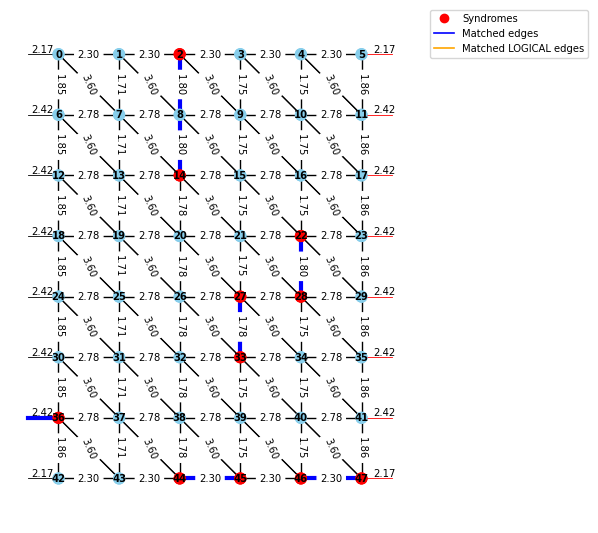

-----flat-----


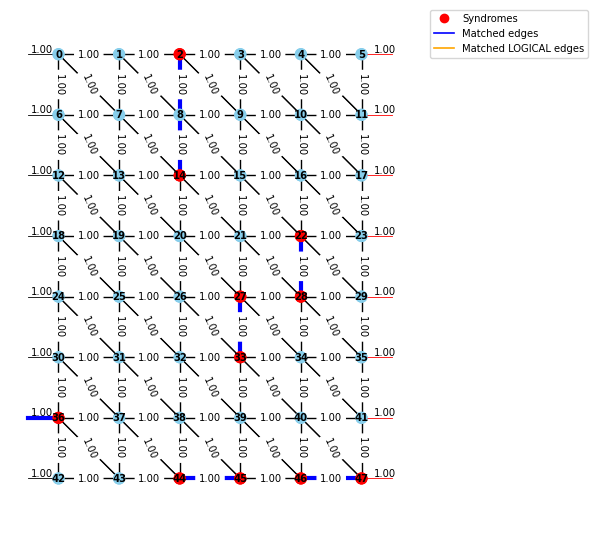

-----INFORMED-----


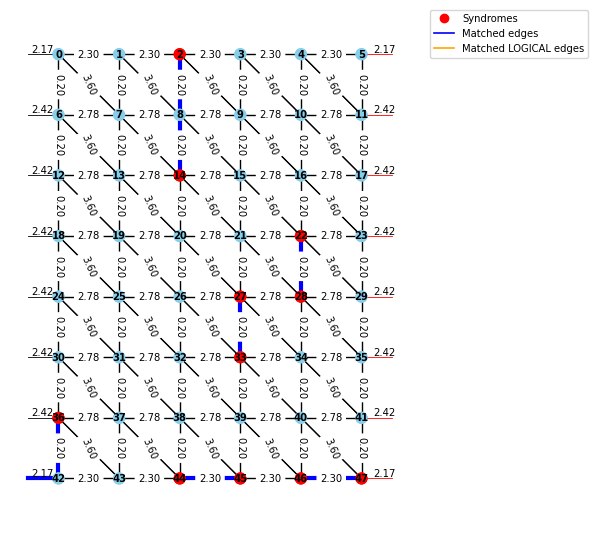

In [27]:
from soft_info import draw_matching_graph


index = 208

fig_size = (4, 13)
scale_factor = 0.6

to_be_result = result
details = to_be_result.error_details[index]
print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print("-----flat-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
print("-----INFORMED-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [28]:
print("indices that are in informed but not in IQ:")
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print(informed_not_in_iq)
print("indices that are in IQ but not in informed:")
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print(iq_not_in_informed)

print()

print("indices that are in IQ but not in flat:")
iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print(iq_not_in_flat)
print("indices that are in flat but not in IQ:")
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print(flat_not_in_iq)



indices that are in informed but not in IQ:
[4818]
indices that are in IQ but not in informed:
[338, 856, 932, 982, 1222, 1299, 1536, 2159, 2200, 2345, 2460, 2688, 2943, 2985, 4573, 5203, 5475, 5803, 6019, 7613, 7662, 7664, 8171, 8368, 8625, 9021, 9142, 9857]

indices that are in IQ but not in flat:
[338, 2159, 2460, 2688, 5826, 7662, 9142]
indices that are in flat but not in IQ:
[91, 96, 120, 134, 349, 357, 373, 546, 562, 611, 645, 664, 681, 682, 723, 757, 768, 774, 806, 832, 920, 961, 994, 1033, 1078, 1085, 1200, 1219, 1221, 1226, 1228, 1250, 1257, 1271, 1287, 1297, 1298, 1438, 1452, 1531, 1570, 1605, 1627, 1761, 1841, 1843, 1911, 1957, 1981, 1982, 2035, 2069, 2175, 2201, 2211, 2231, 2385, 2403, 2541, 2639, 2692, 2848, 2974, 3009, 3031, 3035, 3037, 3057, 3087, 3099, 3198, 3214, 3343, 3351, 3377, 3398, 3410, 3467, 3476, 3493, 3526, 3571, 3593, 3622, 3637, 3760, 3794, 3841, 3876, 3985, 3993, 4022, 4080, 4096, 4124, 4137, 4176, 4243, 4485, 4504, 4534, 4555, 4558, 4635, 4651, 4655, 4658,

# Analyse specific shots

{'0000000 011000 000100 000000 110000 000000 010000 000010': 1}
-----IQ-----


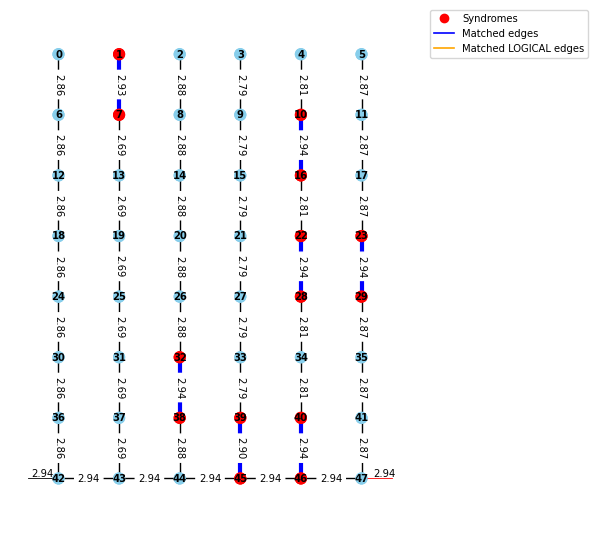

In [14]:
index = 64
IQ_data = extreme_IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True)


print(cpp_soft_info.get_counts(IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]
print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)